# <center> __Practical Assignment: Estimating VAR of a Portfolio.__

___

__Group Assignment:__
- *Ahmed Abdelazeem* (m20210433)
- *João Silva Ferreira* (m20210201)
- *Pedro Moura Gomes* (m20200322)
- *Omar Jarir* (m20201378)

## __The Problem:__

Consider a Russian investor holding a US and German stock portfolio on 09/03/2022.
Suppose that the investment is made in rubles and that:

> _60% of the portfolio is held in US stocks._

> _40% of the portfolio is held in German stocks._

The US portfolio has a $\beta$ of 1.6 relative to the NASDAQ index and the German portfolio has a $\beta$ of 1.3 relative to the DAX index.

In order to evaluate the portfolio risk, you are given the data from NASDAQ 100, DAX and EUR/RUB and USD/RUB exchange rates from 09/02/2017 to 09/03/2022.

Answer all the questions and explain your answers and choices on a report.

__Some Notes on the Formulation:__

1. Note that, for instance, the price of a given US stock, in rubles, is the dollar price multiplied by
   the USD/RUB exchange rate, ie,

   \begin{align}
      P_{t}^{RUB}=P_{t}^{USD}X_{t}^{USD/RUB}
   \end{align}


   Hence, the log equity return and the log forex return are additive, ie,
   
   \begin{align}
 ln\left(\frac{P_{t+1}^{RUB}}{P_{t}^{RUB}}\right)&=ln\left(\frac{P_{t+1}^{USD}}{P_{t}^{USD}}\right)+ln\left(\frac{X_{t+1}^{USD/RUB}}{X_{t}^{USD/RUB}}\right)\Longleftrightarrow\\r_{t}^{RUB}&=r_{t}^{USD}+r_{t}^{USD/RUB}
  \end{align}
    

This means that the risk of a US stock portfolio to a Russian investor has an equity component,
based on the risk of the dollar returns on the portfolio and a forex component, which is based
on the USD/RUB foreign exchange rate.

2. Considering:

- $\omega_{1}$ the proportion of total capital invested in German market.
- $\omega_{2}$ the proportion of total capital invested in US market.
- $\ y_{1t}$ daily log returns on German index.
- $\ y_{2t}$ daily log returns on US index.
- $\ r_{t}^{RUB}$ daily log returns of the total portfolio, in rubles.
- $\ r_{1t}^{RUB}$ daily log returns on the German portfolio.
- $\ r_{2t}^{USD}$ daily log returns on the US portfolio.
- $\ r_{t}^{EUR/RUB}$ daily log returns of the forex rate EUR=RUB.
- $\ r_{t}^{USD/RUB}$ daily log returns of the forex rate USD=RUB.
- $\beta_{1}$ sensitivity of German stocks to DAX index.
- $\beta_{2}$ sensitivity of USD stocks to NASDAQ100.

We may notice that:

   \begin{align}
r_{t}^{RUB}&\simeq\omega_{1}r_{1t}^{RUB}+\omega r_{2t}^{RUB}\\&=\omega_{1}\left(r_{1t}^{EUR}+r_{t}^{EUR/RUB}\right)+\omega_{2}\left(r_{2t}^{USD}+r_{t}^{^{USD/RUB}}\right)\\&=\left(\omega_{1}\beta_{1}y_{1t}^{EUR}+\omega_{2}\beta_{2}y_{2t}^{USD}\right)+\left(\omega_{1}r_{t}^{EUR/RUB}+\omega_{2}r_{t}^{USD/RUB}\right)
  \end{align}

where:

- $\omega_{1}\beta_{1}y_{1t}^{EUR}+\omega_{2}\beta_{2}y_{2t}^{USD}$ corresponds to the net equity return of the portfolio.
- $\omega_{1}r_{t}^{EUR/RUB}+\omega_{2}r_{t}^{USD/RUB}$ corresponds to the net forex return of the portfolio.

__Importing the necessary libraries:__

In [1]:
import time
t1 = time.perf_counter()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib import dates as mdates
from scipy.stats import norm
sns.set()

In [3]:
omega1 = 0.4 
omega2 = 0.6
beta1 = 1.3
beta2 = 1.6

In [4]:
import warnings
warnings.filterwarnings("ignore")

__Loading the dataset:__

In [5]:
import requests as rq
from io import BytesIO

url = "https://raw.githubusercontent.com/omarja12/Market_Risk/main/2122_RM_Data.xlsx"

data = rq.get(url).content

# Loading the dataset:
ds = pd.read_excel(BytesIO(data))
#ds = pd.read_excel('2122_RM_Data.xlsx')

In [6]:
# Converting the date to datetime:

ds['Date'] = pd.to_datetime(ds['Date'])

In [7]:
# Converting objects to float:

for c in ['DAX', 'NASDAQ100']:
    ds[c] = ds[c].apply(lambda x: x.replace(',', '')) 
    ds[c] = pd.to_numeric(ds[c])

In [8]:
# Sorting the dataframe by date and resetting the index.

ds = ds.sort_values(by="Date")
ds.reset_index(drop=True, inplace=True)

In [9]:
ds

,Date,DAX,NASDAQ100,EUR/RUB,USD/RUB
0,2017-02-09,11642.86,5212.16,61.9424,58.9600
1,2017-02-10,11666.97,5226.69,61.4520,58.2219
2,2017-02-13,11774.43,5256.82,60.4012,57.9851
3,2017-02-14,11771.81,5271.07,60.7171,57.1288
4,2017-02-15,11793.93,5302.39,61.4459,57.2565
...,...,...,...,...,...
1229,2022-03-03,13698.40,14035.21,117.6000,109.8960
1230,2022-03-04,13094.54,13837.83,118.9925,122.5375
1231,2022-03-07,12834.65,13319.38,118.9925,143.0000
1232,2022-03-08,12831.51,13267.61,118.9925,127.5000


___

# __Part 1:__

## __Question 1:__
    - Plot the evolution of both indexes and of the foreign exchange rates over the sample period.
    Comment.

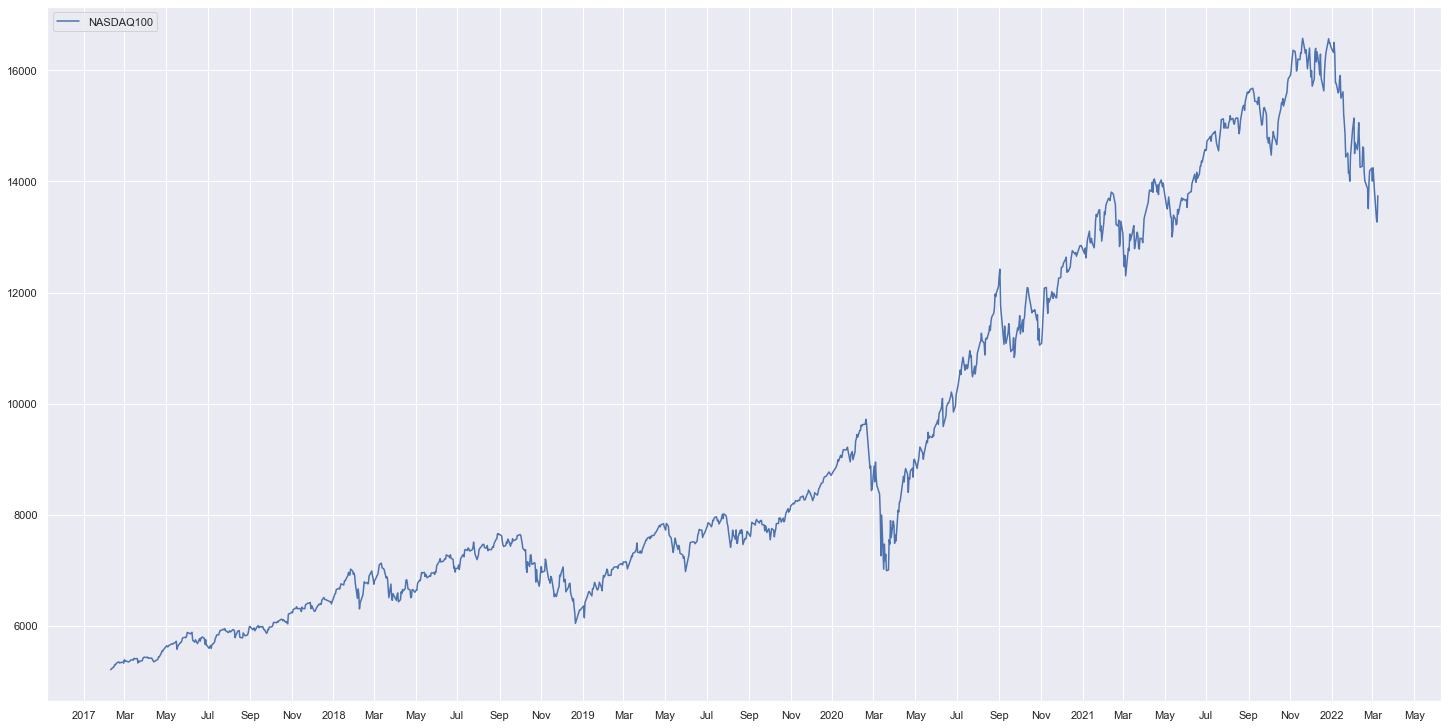

In [10]:
# Plotting the Nasdaq100 index:

fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds["NASDAQ100"]) 
ax.legend(["NASDAQ100"],loc="upper left")
fig.show();

- We can see a decrease in the value of the NASDAQ100 index in February 2022 which corresponds to the beginning of Russia war on Ukraine, and on february 2020 which corresponds to the beginning of the covid19 pandemic.

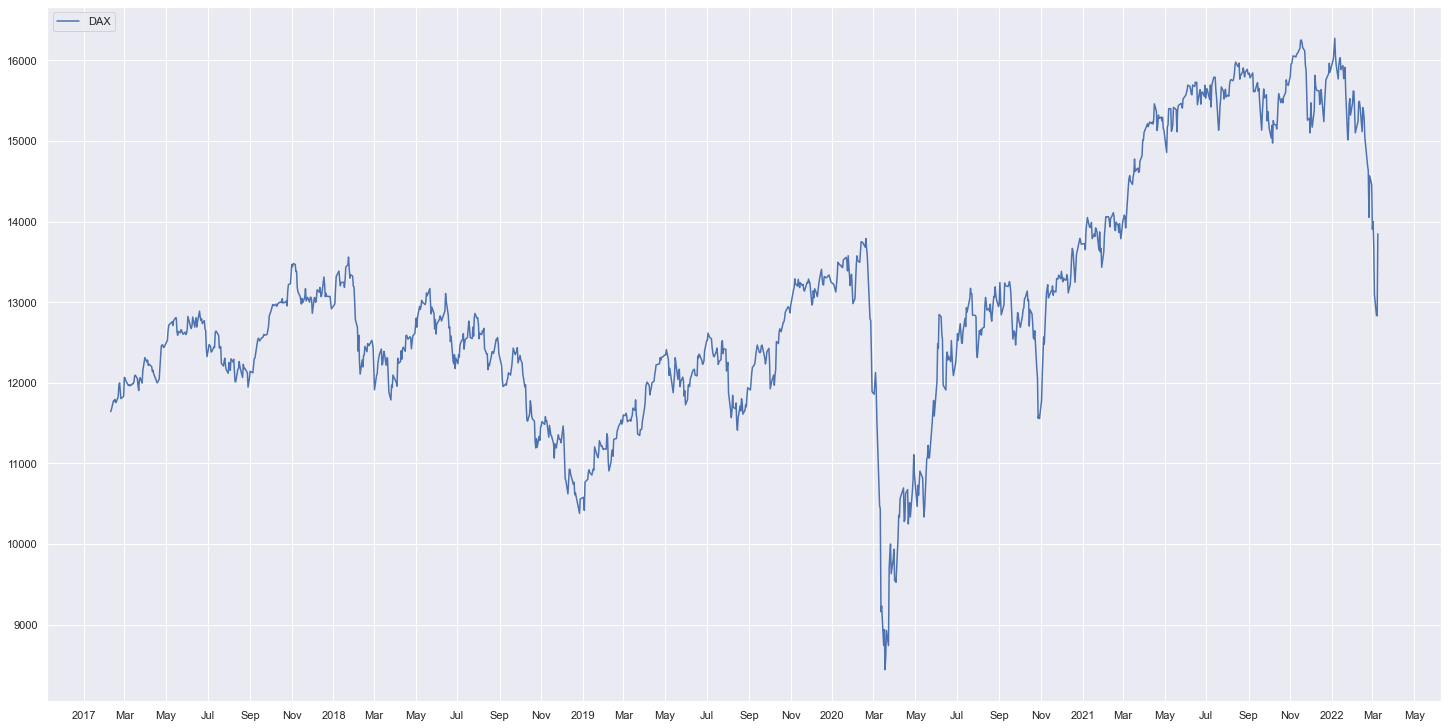

In [11]:
# Plotting the DAX index.

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds["DAX"]) 
ax.legend(["DAX"],loc="upper left")
fig.show();

- We can see a decrease in the value of the DAX index in February 2022 which corresponds to the beginning of Russia war on Ukraine, and on february 2020 which corresponds to the beginning of the covid19 pandemic.

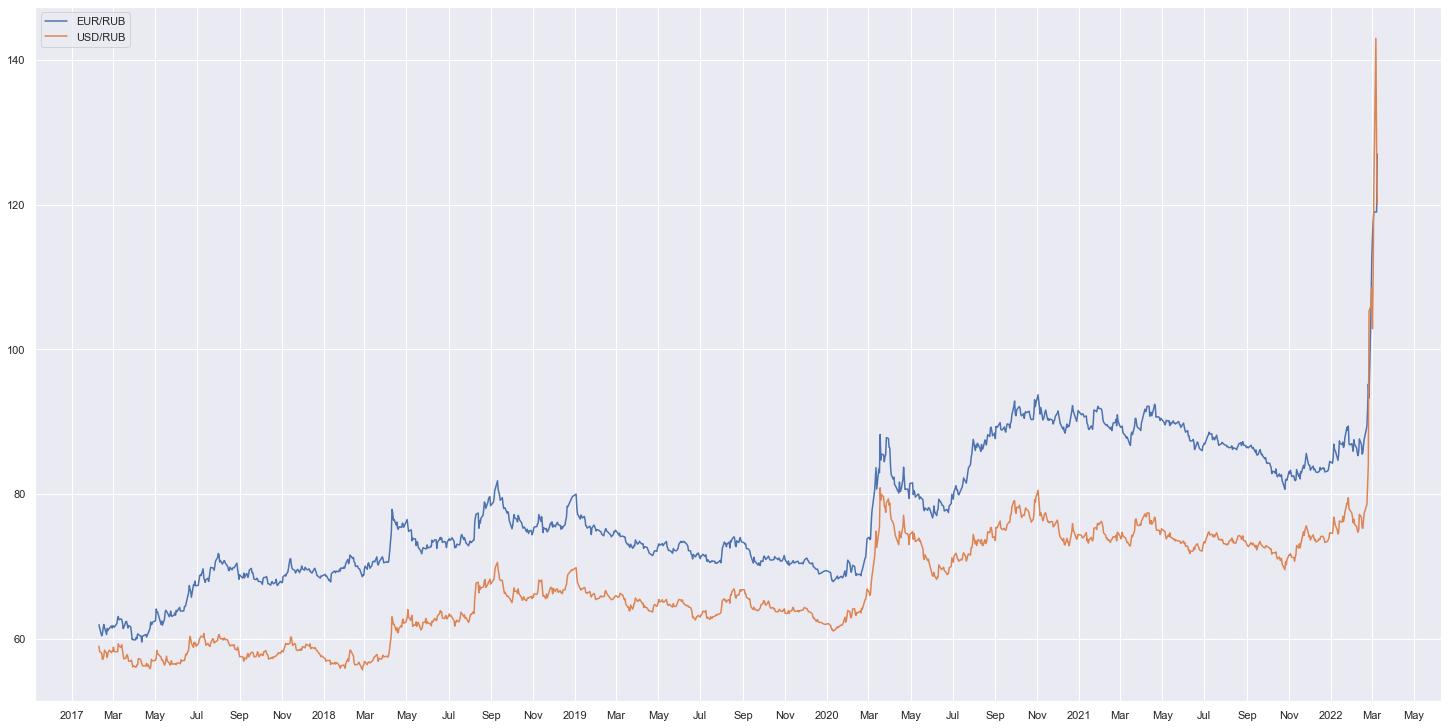

In [12]:
# Plotting the foreign exchange rates.

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds[['EUR/RUB', 'USD/RUB']]) 
ax.legend(['EUR/RUB', 'USD/RUB'],loc="upper left")
fig.show();

- From the plot above we can we that the exchange values of EUR/RUB and USD/RUB increase, meaning the rubble loses its value starting february 2022, which corresponds to the beginning of Russia war on Ukraine.

## __Question 2:__
    - Express the DAX and NASDAQ100 values in rubles and plot them again. Comment.

In [13]:
ds['DAX_RUB'] = ds['DAX']*ds['EUR/RUB']
ds['NASDAQ100_RUB'] = ds['NASDAQ100']*ds['USD/RUB']

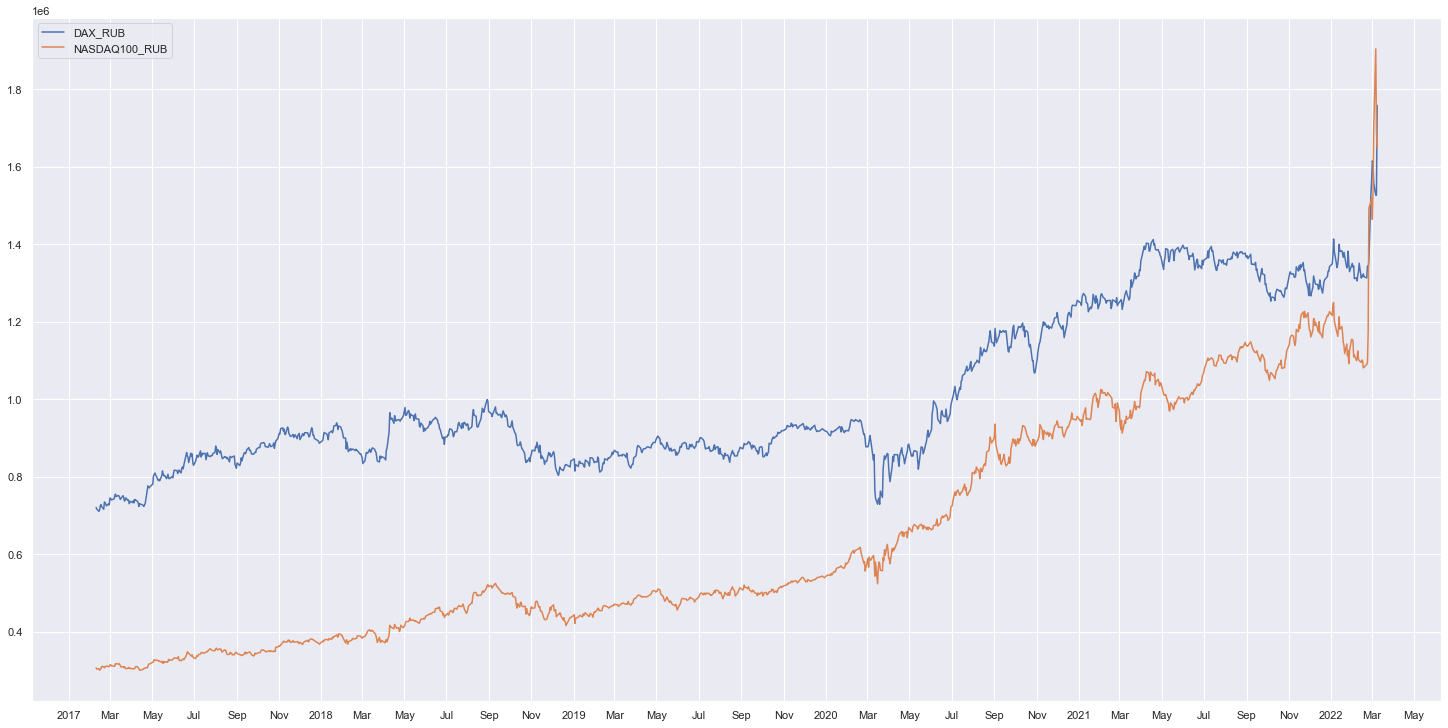

In [14]:
# Plotting the indexes in RUB.

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds[['DAX_RUB', 'NASDAQ100_RUB']]) 
ax.legend(['DAX_RUB', 'NASDAQ100_RUB'],loc="upper left")
fig.show();

- From the Plot above we can see that the value of indexes in rubles increases a lot in February 2022, which corresponds to the beginning of Russia war on Ukraine.

## __Question 3:__
    - Obtain the daily net equity returns and the daily net forex returns of the portfolio. Plot them
    and comment.

In [15]:
ds['y_1t'] = np.log1p(ds['DAX'].pct_change().fillna(0))

ds['y_2t'] = np.log1p(ds['NASDAQ100'].pct_change().fillna(0)) 

In [16]:
ds['rt_EUR/RUB'] = np.log1p(ds['EUR/RUB'].pct_change().fillna(0))

ds['rt_USD/RUB'] = np.log1p(ds['USD/RUB'].pct_change().fillna(0))

In [17]:
# The Equity return is defined as follow:

ds['Equity_return'] = omega1*beta1*ds['y_1t'] + omega2*beta2*ds['y_2t']

# The Forex return is defined as follow:

ds['Forex_return'] = omega1*ds['rt_EUR/RUB'] + omega2*ds['rt_USD/RUB']

In [18]:
ds.head()

,Date,DAX,NASDAQ100,EUR/RUB,USD/RUB,DAX_RUB,NASDAQ100_RUB,y_1t,y_2t,rt_EUR/RUB,rt_USD/RUB,Equity_return,Forex_return
0,2017-02-09,11642.86,5212.16,61.9424,58.9600,721186.691264,307308.953600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017-02-10,11666.97,5226.69,61.4520,58.2219,716958.640440,304307.822511,0.002069,0.002784,-0.007949,-0.012598,0.003748,-0.010738
2,2017-02-13,11774.43,5256.82,60.4012,57.9851,711189.701316,304817.233382,0.009168,0.005748,-0.017247,-0.004075,0.010286,-0.009344
3,2017-02-14,11771.81,5271.07,60.7171,57.1288,714750.164951,301129.903816,-0.000223,0.002707,0.005216,-0.014878,0.002483,-0.006840
4,2017-02-15,11793.93,5302.39,61.4459,57.2565,724688.643387,303596.293035,0.001877,0.005924,0.011932,0.002233,0.006664,0.006112


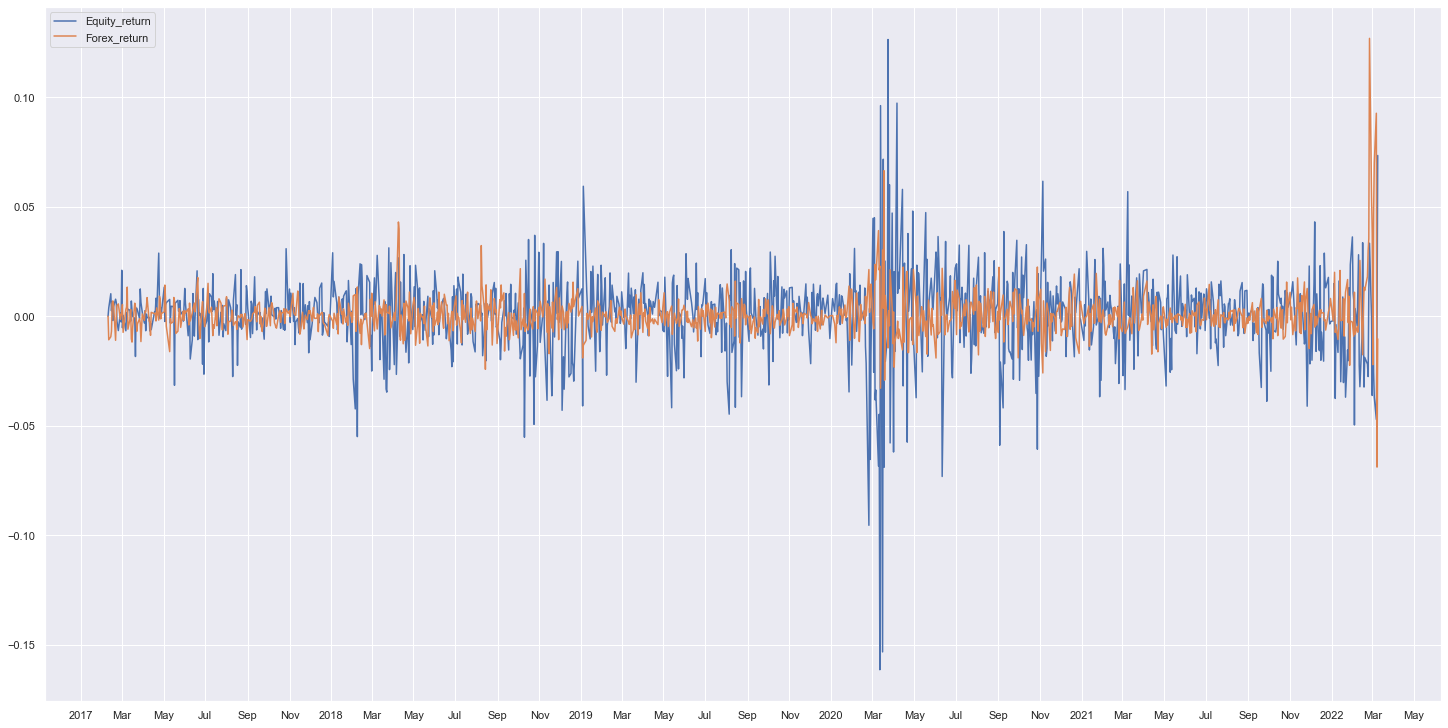

In [19]:
# Plotting the daily net equity and forex returns:

fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds[["Equity_return", "Forex_return"]]) 
ax.legend(["Equity_return", "Forex_return"],loc="upper left")
fig.show();

   - We can see a big variability of returns on march 2020 which corresponds to the beginning of the covid19 pandemic, and also on February 2022 which correspond to the beginning of Russia war on Ukraine.

## __Question 4:__
    - Obtain the daily portfolio returns and plot them on an histogram. Comment on the shape of
    the distribution.

In [20]:
# The daily portfolio return is given by:

ds['rt_RUB'] = ds['Equity_return'] + ds['Forex_return']

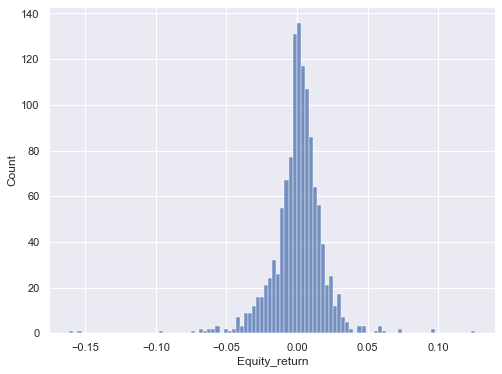

In [21]:
# Histogram of the the Equity returns. 

fig=plt.figure(figsize=(8,6))
sns.histplot(data=ds, x='Equity_return', bins=100)
plt.show();

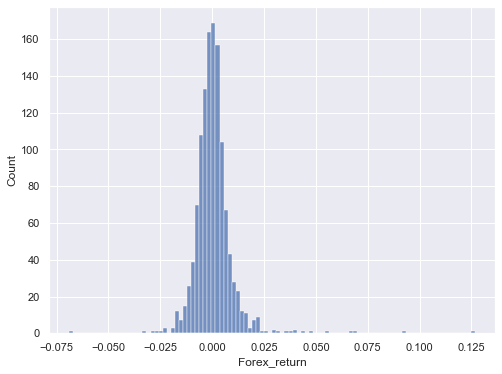

In [22]:
# Histogram of the the Forex returns.

fig=plt.figure(figsize=(8,6))
sns.histplot(data=ds, x='Forex_return', bins=100)
plt.show();

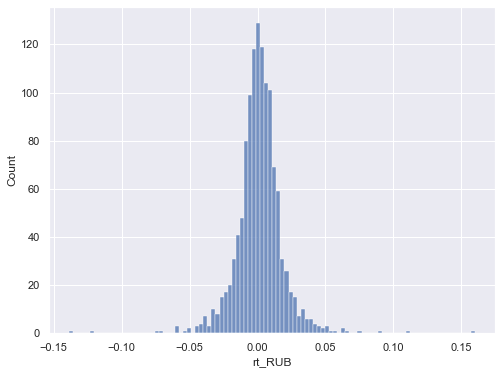

In [23]:
# Histogram of the returns.

fig=plt.figure(figsize=(8,6))
sns.histplot(data=ds, x='rt_RUB', bins=100)
plt.show();

In [24]:
print("The returns means is equal to:", ds["rt_RUB"].mean())
print("The returns standard deviation is equal to:", ds["rt_RUB"].std())

The returns means is equal to: 0.001405559555246771
The returns standard deviation is equal to: 0.01758189088056732


- The distribution looks symetrical with a bell shape, which makes us guess of a normally distributed returns.

___

# __Part 2:__
   - Considering a smoothing parameter of lambda $\lambda=0.94$, obtain:

In [25]:
lbd=0.94;  

## __Question 1:__
    - The EWMA volatilities and correlations over the sample period for the net equity returns and
      forex returns.

The EWMA for the variance estimate, at time t, for a series of returns $\left\{ r_{t}\right\} _{t=1}^{T}$ can be obtained recursively from:

\begin{align}
\hat{\sigma}_{t}^{2}=\left(1-\lambda\right)r_{t-1}^{2}+\lambda\hat{\sigma}_{t-1}^{2},\quad t=2,...,T
\end{align}

and 
\begin{align}
\hat{\sigma}_{1}^{2}=\frac{1}{T}\sum_{i=1}^{T}r_{i}^{2}
\end{align}

In [26]:
ds['Equity_Adjusted_Variance'] = 0
ds['Equity_Adjusted_Variance'].iloc[0] = (ds['Equity_return']*ds['Equity_return']).mean()

ds['Forex_Adjusted_Variance'] = 0
ds['Forex_Adjusted_Variance'].iloc[0] = (ds['Forex_return']*ds['Forex_return']).mean()

In [27]:
# Class 3, page 30. 

for i in range(1,ds.shape[0]):
    ds.loc[i, 'Equity_Adjusted_Variance'] = (1-lbd)*ds.loc[i-1, 'Equity_return']**2 + lbd*ds.loc[i-1, 'Equity_Adjusted_Variance']
    ds.loc[i, 'Forex_Adjusted_Variance'] = (1-lbd)*ds.loc[i-1, 'Forex_return']**2 + lbd*ds.loc[i-1, 'Forex_Adjusted_Variance']

In [28]:
ds['Equity_Adjusted_Volatility'] = np.sqrt(ds['Equity_Adjusted_Variance'])
ds['Forex_Adjusted_Volatility'] = np.sqrt(ds['Forex_Adjusted_Variance'])

- Now we need to estimate the correlations:

The EWMA covariance estimate, at time t, for two contemporaneous time series of returns $\left\{ r_{1,t}\right\} _{t=1}^{T}$ and $\left\{ r_{2,t}\right\} _{t=1}^{T}$ can be obtained recursively from:

\begin{align}
cov\left(r_{1,t},r_{2,t}\right)=\left(1-\lambda\right)r_{1,t-1}r_{2,t-1}+\lambda cov\left(r_{1,t-1},r_{2,t-1}\right),\quad t=2,...,T
\end{align}

and 
\begin{align}
cov\left(r_{1,1},r_{2,1}\right)=\frac{1}{T}\sum_{i=1}^{T}r_{1,i}r_{2,i}
\end{align}

In [29]:
ds['Covariance'] = 0

ds['Covariance'].iloc[0] = (ds['Forex_return']*ds['Equity_return']).mean()

In [30]:
# Class 3, page:31

for i in range(1,ds.shape[0]):   
    ds.loc[i, 'Covariance'] = (1-lbd)*ds.loc[i-1, 'Forex_return']*ds.loc[i-1, 'Equity_return']  + lbd*ds.loc[i-1, 'Covariance']

In [31]:
# The correlation is given by:

ds['Correlation'] = ds['Covariance']/(ds['Equity_Adjusted_Volatility']*ds['Forex_Adjusted_Volatility'])

In [32]:
ds[["Date", "Equity_Adjusted_Volatility", "Forex_Adjusted_Volatility", "Correlation"]]

,Date,Equity_Adjusted_Volatility,Forex_Adjusted_Volatility,Correlation
0,2017-02-09,0.018434,0.009555,-0.341411
1,2017-02-10,0.017873,0.009264,-0.341411
2,2017-02-13,0.017353,0.009359,-0.342061
3,2017-02-14,0.017012,0.009358,-0.364239
4,2017-02-15,0.016505,0.009226,-0.364632
...,...,...,...,...
1229,2022-03-03,0.023034,0.035537,-0.022177
1230,2022-03-04,0.023188,0.036351,-0.106063
1231,2022-03-07,0.024243,0.039197,-0.252235
1232,2022-03-08,0.026182,0.044264,-0.420273


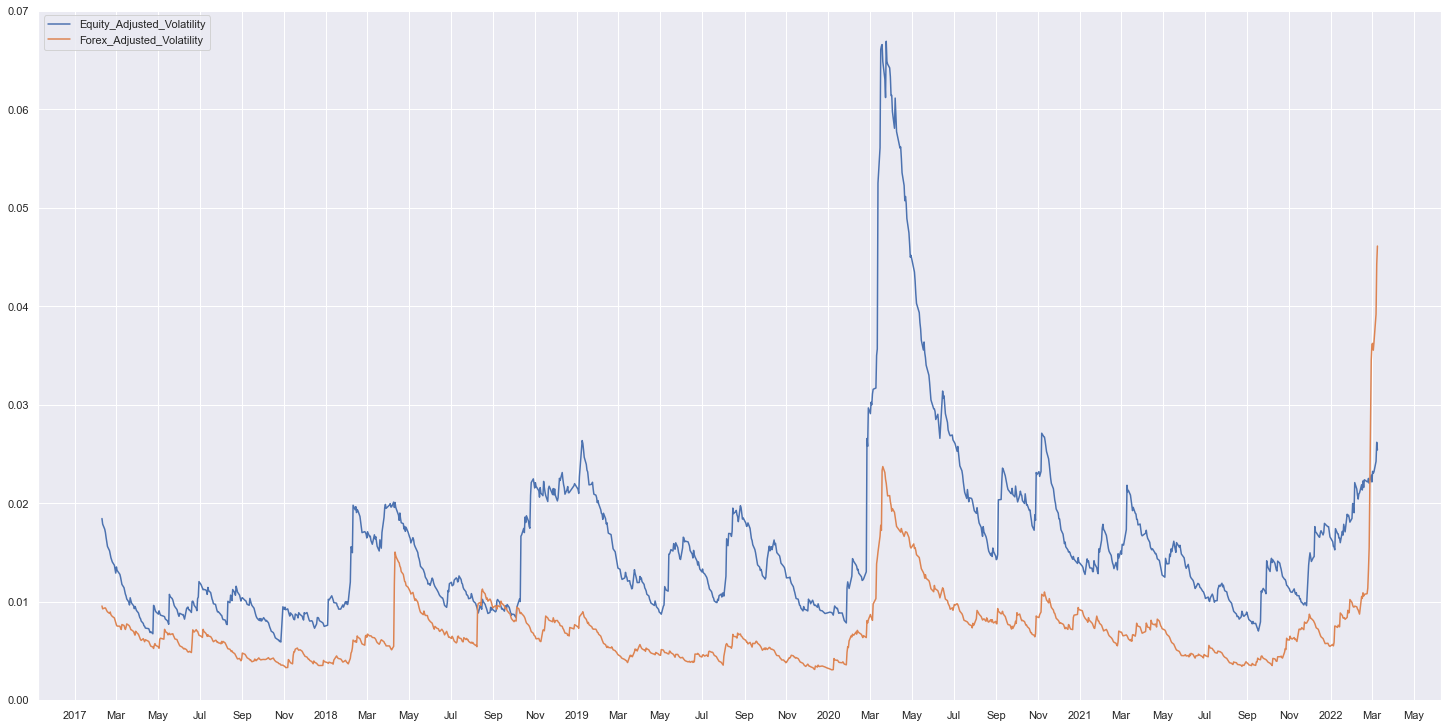

In [33]:
# Plotting the EMWA volatilities:

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds[["Equity_Adjusted_Volatility", "Forex_Adjusted_Volatility"]]) 
ax.legend(["Equity_Adjusted_Volatility", "Forex_Adjusted_Volatility"], loc="upper left")
fig.show();

- We can see a spike on the Equity adjusted volatility on march 2020 maybe due to covid19 pandemic, same for Forex adjusted volatility but with a less magnitude, on February 2022 the Forex adjusted volatility increases exponentially probably due to Russia war on Ukraine.

## __Question 2:__
    - Calculating the adjusted portfolios returns, and comparing them with the original ones.

- Using the following formula $\tilde{r}_{t,T}=\frac{\hat{\sigma}_{T}}{\hat{\sigma}_{t}}r_{t}$, $t=1,...,T$, we have:

In [34]:
# Class 4, page:18.

ds['Adjusted_Equity_return'] = ds['Equity_return'] \
                *(ds.loc[ds.shape[0]-1, 'Equity_Adjusted_Volatility']/ds['Equity_Adjusted_Volatility'])

ds['Adjusted_Forex_return'] = ds['Forex_return'] \
                *(ds.loc[ds.shape[0]-1, 'Forex_Adjusted_Volatility']/ds['Forex_Adjusted_Volatility'])

In [35]:
# Class 4, page:18.

ds['Adjusted_Equity_return_23'] = ds['Equity_return'] \
                *(ds[ds['Date'] == '2022-02-23']["Equity_Adjusted_Volatility"].values[0]/ds['Equity_Adjusted_Volatility'])

ds['Adjusted_Forex_return_23'] = ds['Forex_return'] \
                *(ds[ds['Date'] == '2022-02-23']["Forex_Adjusted_Volatility"].values[0]/ds['Forex_Adjusted_Volatility'])

- Comparing the returns, and commenting. 

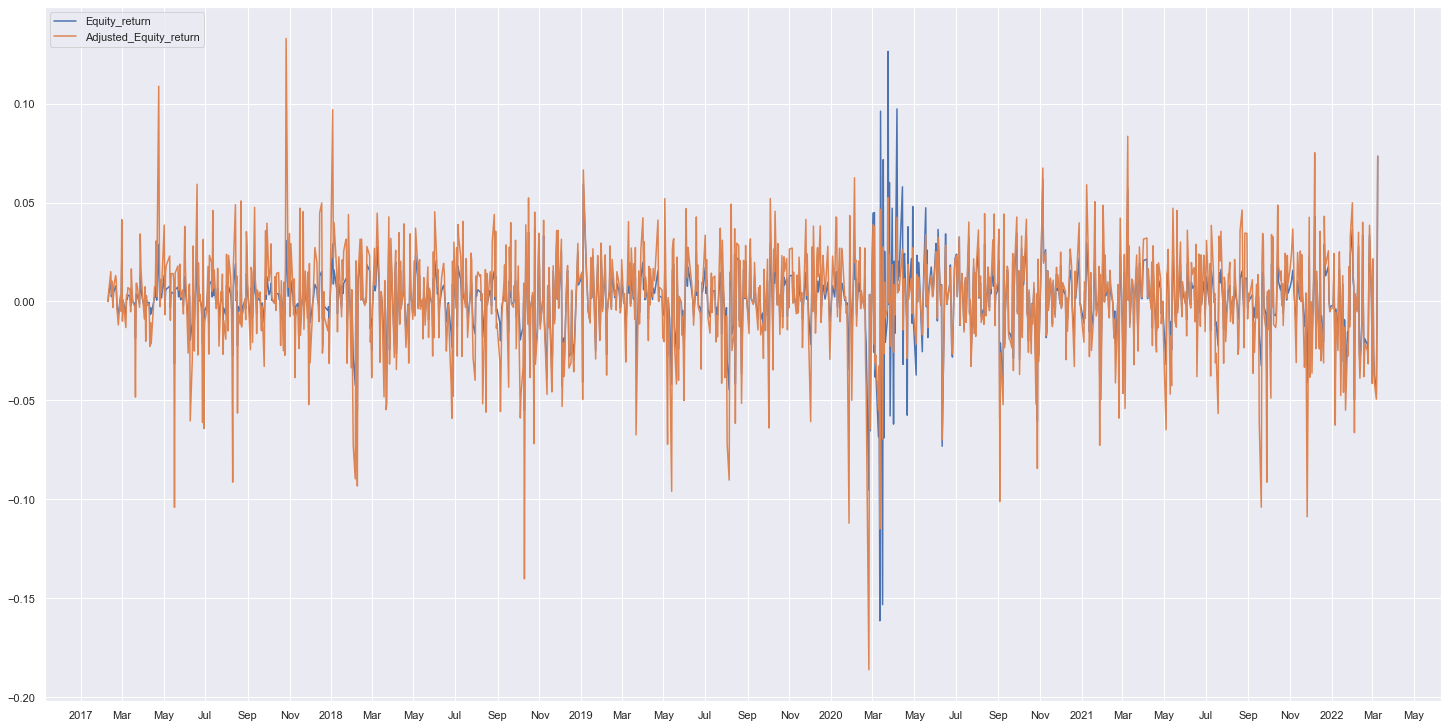

In [36]:
# Plotting and comparing "Equity_return" and "Adjusted_Equity_return".

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds[['Equity_return', 'Adjusted_Equity_return']]) 
ax.legend(['Equity_return', 'Adjusted_Equity_return'],loc="upper left")
fig.show();

- From the plot above we can see that the adjusted Equity return is a lot more volatile that the Equity return, which is normal as this methodology is designed to weight returns in such a way that we adjust their volatility to the current volatility.

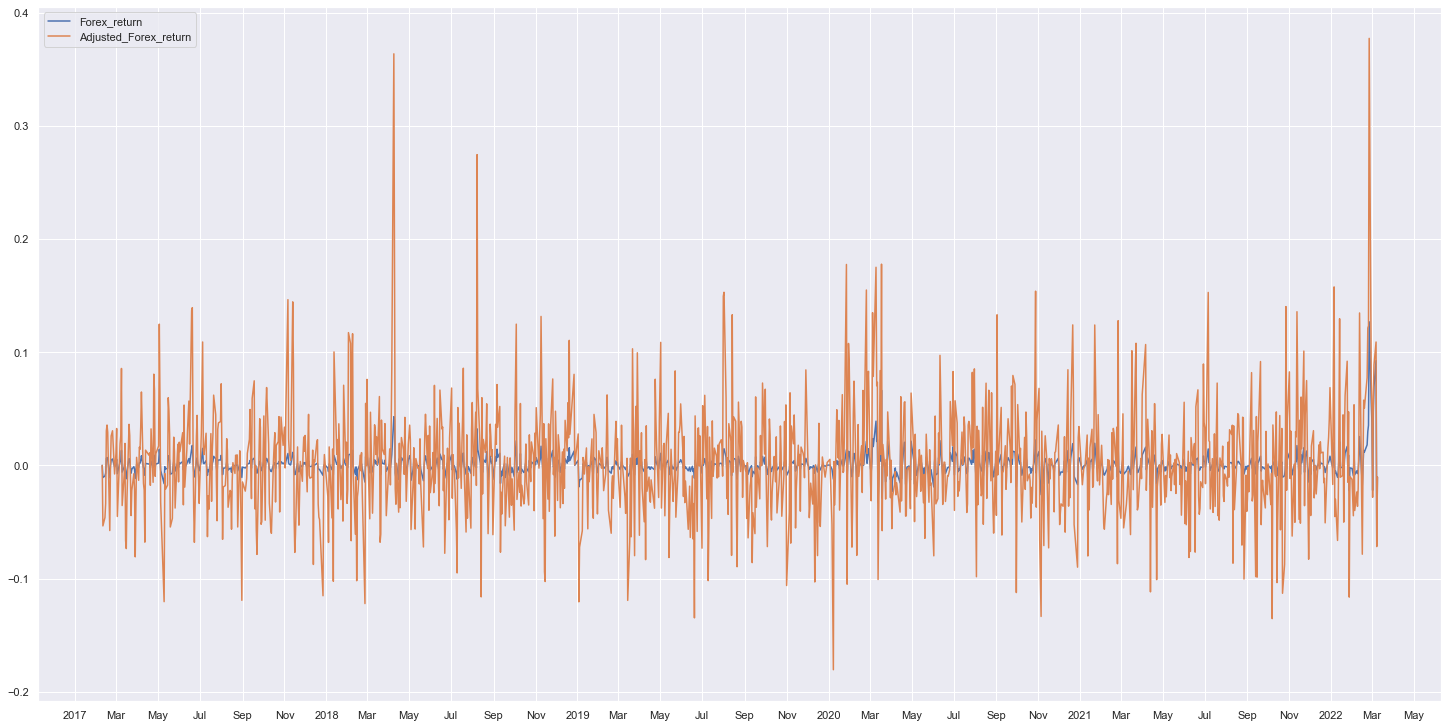

In [37]:
# Plotting and comparing "Forex_return" and "Adjusted_Forex_return".

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds[['Forex_return', 'Adjusted_Forex_return']]) 
ax.legend(['Forex_return', 'Adjusted_Forex_return'],loc="upper left")
fig.show();

- From the plot above we can see that the adjusted Forex return is a lot more volatile that the Forex return, which is normal as this methodology is designed to weight returns in such a way that we adjust their volatility to the current volatility.

## __Question 3:__
    - Estimate the EWMA annual covariance matrix of the portfolio on 09/03/2022. Compare to the
      obtained from data at 23/02/2022. Comment.

In [38]:
trading_days=250

__On 09/03/2022, we have:__

The Annual volatility Nasdaq100 and Dax are given by: 

In [39]:
Equity_vol_09 = ds.loc[ds.shape[0]-1, 'Equity_Adjusted_Volatility']
Forex_vol_09 = ds.loc[ds.shape[0]-1, 'Forex_Adjusted_Volatility']

In [40]:
a12 = ds.loc[ds.shape[0]-1, 'Covariance']
a11 = Equity_vol_09**2
a22 = Forex_vol_09**2

Annual_Covariance_Matrix_09 = trading_days*np.matrix([[a11, a12], [a12, a22]])

In [41]:
pd.DataFrame(Annual_Covariance_Matrix_09, columns =["Equity", "Forex"], index=["Equity", "Forex"])

,Equity,Forex
Equity,0.161312,-0.110467
Forex,-0.110467,0.531522


__On the 23/02/2022, we have:__

In [42]:
Equity_vol_23 = ds[ds['Date'] == '2022-02-23']['Equity_Adjusted_Volatility'].values[0]
Forex_vol_23 = ds[ds['Date'] == '2022-02-23']['Forex_Adjusted_Volatility'].values[0]

In [43]:
a12 = ds[ds['Date'] == '2022-02-23']['Covariance'].values[0]
a11 = Equity_vol_23**2
a22 = Forex_vol_23**2

Annual_Covariance_Matrix_23 = trading_days*np.matrix([[a11, a12], [a12, a22]])

In [44]:
pd.DataFrame(Annual_Covariance_Matrix_23, columns=["Equity", "Forex"],index=["Equity", "Forex"])

,Equity,Forex
Equity,0.122700,-0.038781
Forex,-0.038781,0.032370


- The variances went up after the war started, especially the Forex variance that went from a value equal to 0.032 to a value of 0.53, the Equity and Forex are also more negatively correlated, meaning that when the Equity go down the forex goes up and vice-versa. 

___

# __Part 3:__
    - Using the adjusted returns obtained in Question II.2, considering both dates 09/03/2022 and 23/02/2022
      and setting a 1% significance level:

## __Question 1:__
    - Obtain the 1-day and 10-day Normal Parametric Systematic VaR for the portfolio. Comment. 

In a linear portfolio with $m$ risk factors it may be represented as a weighted 
sum:

\begin{align}
Y=\sum_{i=1}^{m}\theta_{i}X_{i}
\end{align}
With: 

$X_{i}$- return on the $i^{th}$ risk.

$\theta_{i}$- portfolio's sensitivity to the $i^{th}$ risk factor.

In [45]:
alpha = 0.01
h_1 = 1
h_10 = 10

The Normal Parametric Systematic Var for the portfolio is given by:

Assuming that the values of $\theta_{1}=1$ and $\theta_{2}=1$. 
And we know the formula:

\begin{align}
Systematic\qquad Var_{h,\alpha}=\phi^{-1}\left(1-\alpha\right)\sqrt{\theta'\Omega_{h}\theta}
\end{align}

__1 day Var:__

__The 1 day Var on the 09/03/2022 is equal to:__

In [46]:
def AnnualVariance(sensitivity, cov):
    return np.matmul(np.matmul(sensitivity, cov), sensitivity.T)

def VaRs(alpha, days, sensitivity, cov):
    av = AnnualVariance(sensitivity, cov)
    return np.sqrt(days/trading_days)*norm.ppf(1- alpha)*np.sqrt(av) 

In [48]:
# Class 3, page: 15.
Var_1_09 = VaRs(alpha, h_1, np.array([1,1]), Annual_Covariance_Matrix_09)[0,0]
Var_1_09

0.10107158559280117

__The 1 day Var on the 23/02/2022 is equal to:__

In [49]:
Var_1_23 = VaRs(alpha, h_1, np.array([1,1]), Annual_Covariance_Matrix_23)[0,0]
Var_1_23

0.04096180083398142

- We can see that the value of the Var of the portfolio increased with time, the portfolio Var on the 23/02/2022 is equal to 0.04 while on 09/03/2022 the portfolio Var is equal to 0.10.

__10 Days Var:__

__The 10 days Var on the 09/03/2022 is equal to:__

In [50]:
Var_10_09 = VaRs(alpha, h_10, np.array([1,1]), Annual_Covariance_Matrix_09)[0,0]
Var_10_09

0.31961641719791145

__The 10 days Var on the 23/02/2022 is equal to:__

In [51]:
Var_10_23 = VaRs(alpha, h_10, np.array([1,1]), Annual_Covariance_Matrix_23)[0,0]
Var_10_23

0.12953258769756593

In [52]:
pd.DataFrame([[Var_1_23, Var_1_09], [Var_10_23, Var_10_09]],
             columns = ["23/02/2022", "09/03/2022"], index=["Var_1", "Var_10"])

,23/02/2022,09/03/2022
Var_1,0.040962,0.101072
Var_10,0.129533,0.319616


- We can see that the value of the Var of the portfolio increased with time, the portfolio 10 days Var on the 23/02/2022 is equal to 0.13 while on 09/03/2022 the portfolio days Var is equal to 0.32.
- Same for the value of 1 day Var that increased from 0.04 to 0.10.

## __Question 2:__
    - Estimate the 10-day Normal Stand-Alone VaR for the equity and forex risk factors on 09/03/2022.
      Comment.

We know that the Equity and Forex Vars are given by the following formulas:

\begin{align}
Equity\qquad Var_{h,\alpha}=\phi^{-1}\left(1-\alpha\right)\sqrt{\theta_{E}'\Omega_{Eh}\theta_{E}}
\end{align}

\begin{align}
Forex\qquad Var_{h,\alpha}=\phi^{-1}\left(1-\alpha\right)\sqrt{\theta_{F}'\Omega_{Fh}\theta_{F}}
\end{align}

__On 23/02/2022__

- __Equity:__

In [53]:
Equity_10_Var_23 = VaRs(alpha, h_10, np.array([1,0]), Annual_Covariance_Matrix_23)[0,0]
Equity_10_Var_23

0.16297698556942639

- __Forex:__

In [54]:
Forex_10_Var_23 = VaRs(alpha, h_10, np.array([0,1]), Annual_Covariance_Matrix_23)[0,0]
Forex_10_Var_23

0.08371034503606199

__On 09/03/2022__

- __Equity:__

In [55]:
Equity_10_Var_09 = VaRs(alpha, h_10, np.array([1,0]), Annual_Covariance_Matrix_09)[0,0]
Equity_10_Var_09

0.1868690779759193

- __Forex:__

In [56]:
Forex_10_Var_09 = VaRs(alpha, h_10, np.array([0,1]), Annual_Covariance_Matrix_09)[0,0]
Forex_10_Var_09

0.33920737911370596

In [57]:
pd.DataFrame([[Equity_10_Var_23, Equity_10_Var_09], [Forex_10_Var_23, Forex_10_Var_09]],
             columns = ["23/02/2022", "09/03/2022"], index=["Equity", "Forex"])

,23/02/2022,09/03/2022
Equity,0.162977,0.186869
Forex,0.083710,0.339207


 - We can see a high increase on the Forex Value that moved from 0.08 to 0.33, the Equity Var increased aswell but not with the same range.

Due to the diversification effect between risk factor types (and variance properties):
   - The sum of the stand-alone Var’s is greater than or equal to the Systematic VaR.
   - Equality only is observed in the trivial case where all risk factors are perfectly correlated.

## __Question 3:__
    - Obtain the 1% 1-day Historical VaR. Comment.

The historical simulation (HS) approach is a nonparametric method that makes no specific assumption about the distribution of risk factors. It consists of going back in time and replaying the tape of history on the current positions. 

__Advantages of Historical VaR__
- Historical VaR does not need any parametric assumptions.
- The dynamic evolution and dependencies of the risk factors are inferred directly from historical observations.
- This allow the model to access the risk of complex path-dependence products.
- Historical VaR includes the dynamic behaviour of risk factors in a natural and realistic manner.
- Historical VaR is not limited to linear portfolios.

__Equally Weighted Returns Distribution__

- With equal weighting, the ordering or the observations is irrelevant, which does not reflect the current market conditions.

- __on the 09/03/2022:__

In [58]:
Hist_var_EWRD_09 = -ds['rt_RUB'].quantile(q=alpha)
Hist_var_EWRD_09

0.0437563582300805

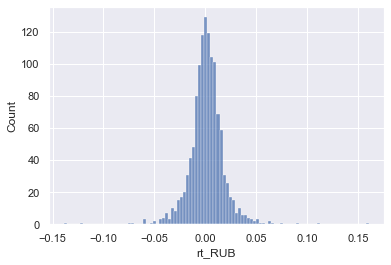

In [59]:
sns.histplot(data=ds, x='rt_RUB')
plt.show();

- __On 23/02/2022:__

In [60]:
Hist_var_EWRD_23 = -ds['rt_RUB'][:ds[ds['Date'] == '2022-02-23'].index[0]].quantile(q=alpha)
Hist_var_EWRD_23

0.04165082772801792

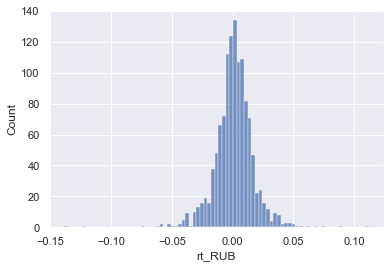

In [61]:
sns.histplot(data=ds[:ds[ds['Date'] == '2022-02-23'].index[0]], x='rt_RUB')
plt.show();                     

In [62]:
pd.DataFrame([[Hist_var_EWRD_23, Hist_var_EWRD_09]],
             columns = ["23/02/2022", "09/03/2022"], index=["Hist_Var_EWRD" ])

,23/02/2022,09/03/2022
Hist_Var_EWRD,0.041651,0.043756


- We can see that the value of the Var slightly increased with time.

__EWMA Returns Distribution:__
- Class 4, page:13.

1. Fix a smoothing constant $0<\lambda<1.$

2. Consider a data set $\left\{ r_{1},...,r_{T}\right\}$  of T most recent portfolio returns.

3. Assign a probability weight to each of the returns as follows:

\begin{align}
\omega_{T}=1-\lambda\qquad and\qquad\omega_{i}=\lambda\omega_{i-1},\quad i=T-1,...,1
\end{align}

4. Use the probability weights to find the cumulative probability associated with the returns, when they are put in increasing order of magnitude.

        - Order increasingly the returns and record it's associated probability weight.

        - Add the weight associated with the next smallest return until reach the significance level.

7. The $100\times\alpha\%$ historical Var, as a percentage of the portfolio's value, is equal to minus the last return taken into the sum.

8. The risk horizon for the Var is the holding period of returns (usually 1 day)

- __On 09/03/2022:__

In [63]:
ds["rt_RUB_weight"] = 0 
ds["rt_RUB_weight"].iloc[ds.shape[0]-1] = 1-lbd

for i in range(2,ds.shape[0]):
    ds["rt_RUB_weight"].iloc[ds.shape[0]-i] = lbd*ds["rt_RUB_weight"].iloc[ds.shape[0]-i+1]

In [64]:
ds_hist_ewma = ds[["rt_RUB", "rt_RUB_weight"]].sort_values(by="rt_RUB")
ds_hist_ewma.reset_index(drop=True, inplace=True)

In [65]:
ds_hist_ewma["Cumulative Probability"]=0
ds_hist_ewma["Cumulative Probability"].iloc[0] = ds_hist_ewma["rt_RUB_weight"].iloc[0]

for i in range(1,ds.shape[0]):
    ds_hist_ewma["Cumulative Probability"].iloc[i] = ds_hist_ewma["rt_RUB_weight"].iloc[i] + ds_hist_ewma["Cumulative Probability"].iloc[i-1]

In [66]:
# Finding the index of the quantile.

s = ds_hist_ewma['Cumulative Probability']
s[s == s.quantile(alpha)].index

Int64Index([11, 12, 13, 14], dtype='int64')

In [67]:
Hist_Var_EWMA_09 =  -ds_hist_ewma["rt_RUB"].iloc[11]
Hist_Var_EWMA_09

0.0448709490402681

In [68]:
print("The value of the historical Var is equal to:", np.round(Hist_Var_EWMA_09, 2))

The value of the historical Var is equal to: 0.04


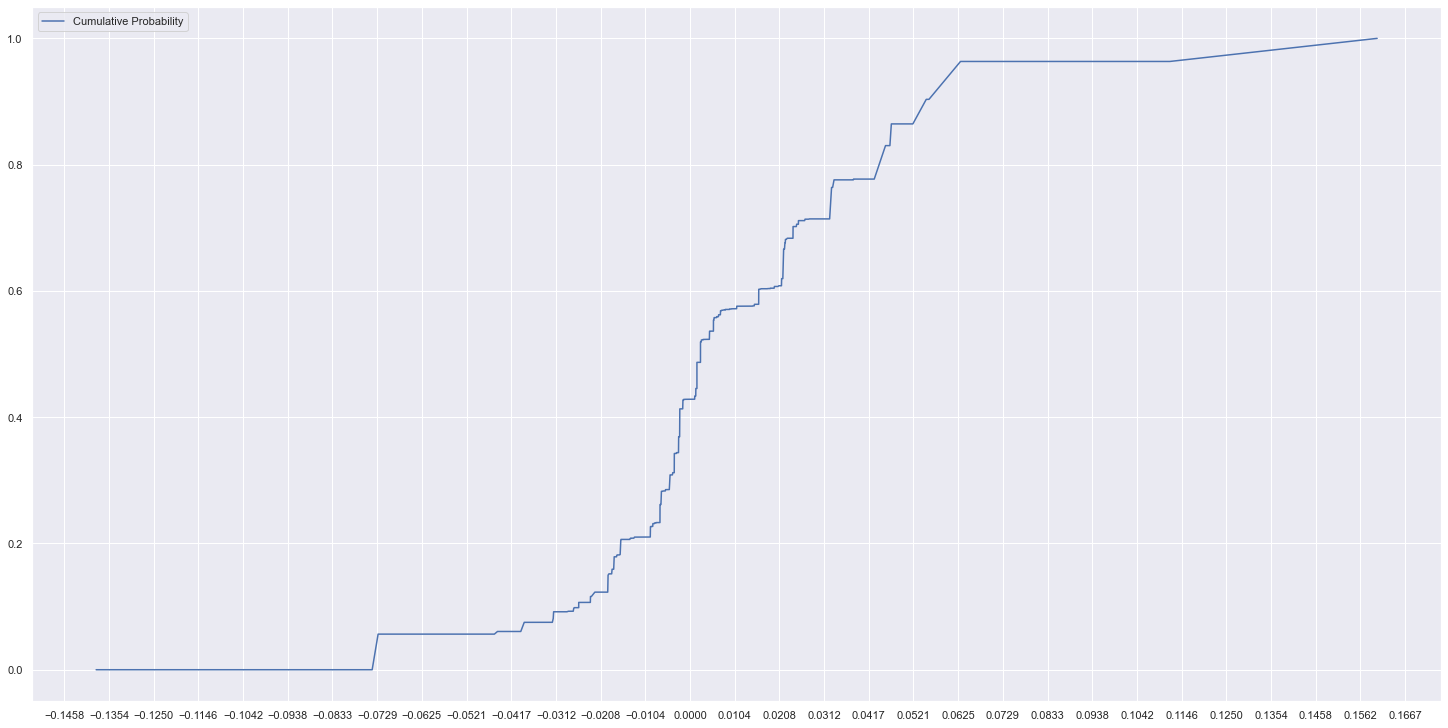

In [69]:
# Plotting the cumulative probability.

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds_hist_ewma["rt_RUB"], ds_hist_ewma['Cumulative Probability']) 
ax.legend(['Cumulative Probability'],loc="upper left")
fig.show();

- The plot above shows the cummulative probability distribution on 09/03/2022.

- __On 23/02/2022:__

In [70]:
ds_23 = ds[:(ds[ds['Date'] == '2022-02-23'].index[0]+1)]

In [71]:
ds_23["rt_RUB_weight"] = 0 
ds_23["rt_RUB_weight"].iloc[ds_23.shape[0]-1] = 1-lbd

for i in range(2,ds_23.shape[0]):
    ds_23["rt_RUB_weight"].iloc[ds_23.shape[0]-i] = lbd*ds_23["rt_RUB_weight"].iloc[ds_23.shape[0]-i+1]

In [72]:
ds_hist_ewma_23 = ds_23[["rt_RUB", "rt_RUB_weight"]].sort_values(by="rt_RUB")
ds_hist_ewma_23.reset_index(drop=True, inplace=True)

In [73]:
ds_hist_ewma_23["Cumulative Probability"]=0
ds_hist_ewma_23["Cumulative Probability"].iloc[0] = ds_hist_ewma_23["rt_RUB_weight"].iloc[0]

for i in range(1,ds_23.shape[0]):
    ds_hist_ewma_23["Cumulative Probability"].iloc[i] = ds_hist_ewma_23["rt_RUB_weight"].iloc[i] + ds_hist_ewma_23["Cumulative Probability"].iloc[i-1]

In [74]:
# Finding the index of the quantile.

s = ds_hist_ewma_23['Cumulative Probability']
s[s == s.quantile(alpha)].index

Int64Index([10, 11, 12, 13], dtype='int64')

In [75]:
Hist_Var_EWMA_23 =  -ds_hist_ewma_23["rt_RUB"].iloc[10]
Hist_Var_EWMA_23

0.0448709490402681

In [76]:
print("The value of the historical Var is equal to:", np.round(Hist_Var_EWMA_23, 2))

The value of the historical Var is equal to: 0.04


In [77]:
pd.DataFrame([[Hist_Var_EWMA_23, Hist_Var_EWMA_09]],
             columns = ["23/02/2022", "09/03/2022"], index=["Hist_Var_EWMA" ])

,23/02/2022,09/03/2022
Hist_Var_EWMA,0.044871,0.044871


- We can see an increase in the value of portfolio Var with time.

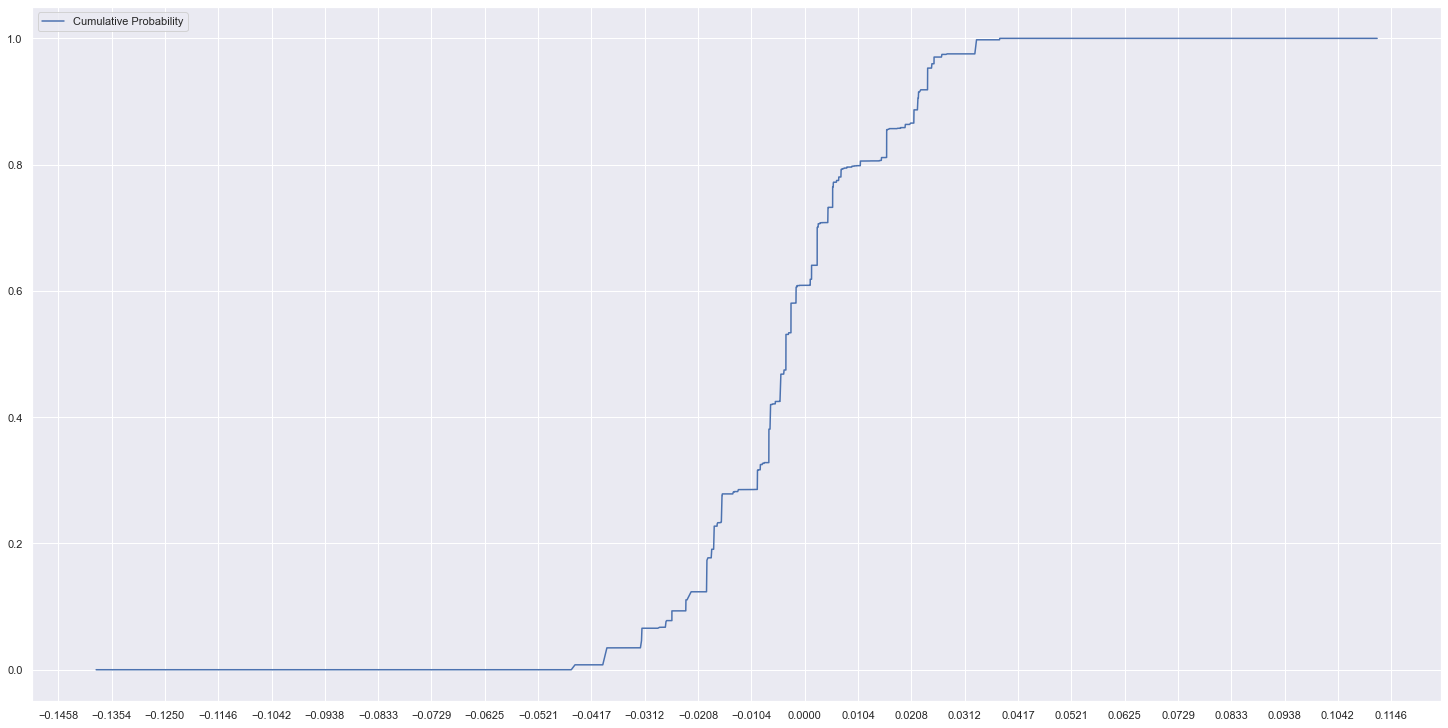

In [78]:
# Plotting the cumulative probability.

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds_hist_ewma_23["rt_RUB"], ds_hist_ewma_23['Cumulative Probability']) 
ax.legend(['Cumulative Probability'],loc="upper left")
fig.show();

- The plot above shows the cummulative probability distribution on 23/02/2022.

__Historical VaR with Volatility Weighting Methodology__

We need to calculate the adjusted return of the portfolio given by: $\tilde{r}_{t,T}=\frac{\hat{\sigma}_{T}}{\hat{\sigma}_{t}}r_{t},\;t=1,...,T$.
Before we need to get the values of the adjusted volatility of returns:

In [79]:
ds['Return_Adjusted_Variance'] = 0
ds['Return_Adjusted_Variance'].iloc[0] = (ds['rt_RUB']*ds['rt_RUB']).mean()

In [80]:
for i in range(1,ds.shape[0]):
    ds.loc[i, 'Return_Adjusted_Variance'] = (1-lbd)*ds.loc[i-1, 'rt_RUB']**2 + lbd*ds.loc[i-1, 'Return_Adjusted_Variance']

In [81]:
ds['Return_Adjusted_Volatility'] = np.sqrt(ds['Return_Adjusted_Variance'])

In [82]:
# The adjusted returns.

ds['Adjusted_rt_RUB'] = ds['rt_RUB'] \
                *(ds.loc[ds.shape[0]-1, 'Return_Adjusted_Volatility']/ds['Return_Adjusted_Volatility'])

ds['Adjusted_rt_RUB_23'] = ds['rt_RUB'] \
                *(ds[ds["Date"]=="23/02/2022"]["Return_Adjusted_Volatility"].values[0]/ds['Return_Adjusted_Volatility'])

- __on the 09/03/2022:__

In [83]:
Hist_Var_VolWeight_09 = -ds['Adjusted_rt_RUB'].quantile(q=alpha)
Hist_Var_VolWeight_09

0.12830567999780115

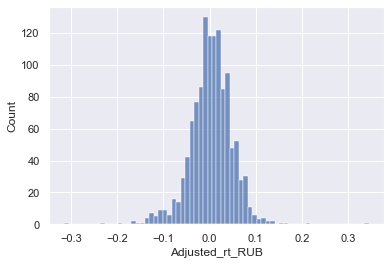

In [84]:
g=sns.histplot(data=ds, x='Adjusted_rt_RUB')
plt.show();

- __On 23/02/2022:__

In [85]:
Hist_Var_VolWeight_23 = -ds['Adjusted_rt_RUB_23'][:ds[ds['Date'] == '2022-02-23'].index[0]].quantile(q=alpha)
Hist_Var_VolWeight_23

0.052063319324968695

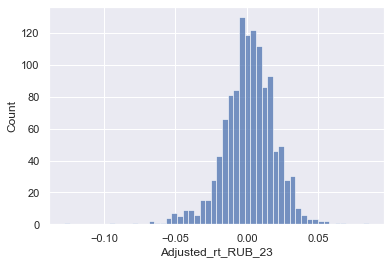

In [86]:
sns.histplot(data=ds[:ds[ds['Date'] == '2022-02-23'].index[0]], x='Adjusted_rt_RUB_23')
plt.show();                     

In [87]:
pd.DataFrame([[Hist_Var_VolWeight_23, Hist_Var_VolWeight_09]],
             columns = ["23/02/2022", "09/03/2022"], index=["Hist_Var_VolWeight" ])

,23/02/2022,09/03/2022
Hist_Var_VolWeight,0.052063,0.128306


 - We can see that the value of the portfolio Var increased with time.

    - Creating an excel sheet.

In [88]:
ds[["Date", "Equity_return", "Equity_Adjusted_Volatility", "Adjusted_Equity_return", "Forex_return", "Forex_Adjusted_Volatility",
   "Adjusted_Forex_return", "rt_RUB", "Return_Adjusted_Volatility", "Adjusted_rt_RUB"]].to_excel("Market_Risk_Project.xlsx")

In [89]:
t2 = time.perf_counter()
print('time taken to run:',(t2-t1))

time taken to run: 22.8410046
